<a href="https://colab.research.google.com/github/BohdanBuhrii/enemy-detection/blob/main/adversarial-examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 15637, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 15637 (delta 123), reused 171 (delta 100), pack-reused 15393
Receiving objects: 100% (15637/15637), 14.58 MiB | 23.30 MiB/s, done.
Resolving deltas: 100% (10652/10652), done.
/content/yolov5/yolov5
Setup complete. Using torch 2.0.0+cu118 (CPU)


In [ ]:
clean_model = '/content/drive/MyDrive/models/1024/1682611017/runs/train/exp/weights/best.pt'
clean_data_yaml = '/content/drive/MyDrive/datasets/vehicles/1024/1682611017/data.yaml'
clean_dataset = '/content/drive/MyDrive/datasets/vehicles/1024/1682611017/'

# Load model with torch

In [145]:
model = torch.hub.load('.', 'custom', path=clean_model, source='local')

requirements: /content/requirements.txt not found, check failed.


YOLOv5 🚀 v7.0-162-gc3e4e94 Python-3.10.11 torch-2.0.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [146]:
model.eval()
type(model)

models.common.AutoShape

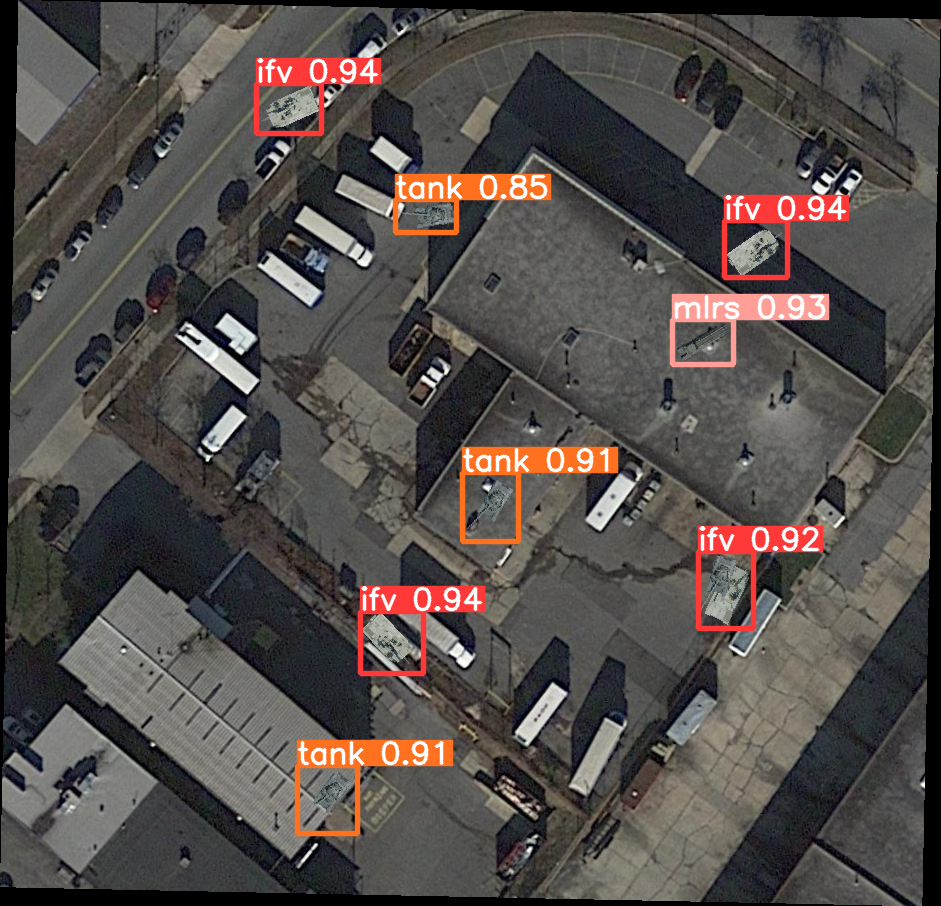

In [173]:
# Image
test_img_path = clean_dataset + "test/images/P0272.png"
#test_img_path = clean_dataset + "test/images/P0548.png"
# Inference
results = model(test_img_path)
# Results, change the flowing to: results.show()
results.show()  # or .show(), .save(), .crop(), .pandas(), etc

In [174]:
results.pandas().xywhn[0]

,xcenter,ycenter,width,height,confidence,class,name
0,0.416717,0.709019,0.067119,0.069065,0.939174,0,ifv
1,0.307113,0.119815,0.068555,0.055877,0.938751,0,ifv
2,0.803790,0.275164,0.067097,0.062677,0.937006,0,ifv
3,0.747019,0.377456,0.064290,0.049803,0.925714,1,mlrs
4,0.771089,0.651146,0.058573,0.084796,0.919173,0,ifv
5,0.521531,0.559425,0.059589,0.076157,0.914861,2,tank
6,0.347836,0.882234,0.063153,0.075645,0.905851,2,tank
7,0.452586,0.237975,0.065414,0.036336,0.848217,2,tank


In [175]:
image = Image.open(test_img_path)
transform = transforms.Compose([
    transforms.Resize((1024,1024)),
    transforms.ToTensor(),
])
t_image = transform(image)
t_image = t_image[None] # add one more dimention for batch
t_image.size()

torch.Size([1, 3, 1024, 1024])

In [180]:
t = model(t_image)
print(t.size())
t[0][1].round()

torch.Size([1, 64512, 8])


tensor([13.,  5., 29., 12.,  0.,  0.,  0.,  0.])

In [177]:
from utils.general import non_max_suppression, scale_boxes

In [178]:
y = non_max_suppression(t)
y[0].round()

tensor([[281.,  95., 349., 151.,   1.,   0.],
        [788., 249., 860., 316.,   1.,   0.],
        [732., 360., 800., 411.,   1.,   1.],
        [390., 689., 458., 762.,   1.,   0.],
        [432., 225., 497., 264.,   1.,   2.],
        [504., 537., 565., 614.,   1.,   2.],
        [322., 866., 390., 943.,   1.,   2.],
        [764., 629., 821., 707.,   1.,   0.]])

In [166]:
scale_boxes((1024,1024), y[0][:, 4], image.size)
y[0].round()

tensor([[281.,  95., 349., 151.,   0.,   0.],
        [788., 249., 860., 316.,   1.,   0.],
        [732., 360., 800., 411.,   0.,   1.],
        [390., 689., 458., 762.,   1.,   0.],
        [432., 225., 497., 264.,   1.,   2.],
        [504., 537., 565., 614.,   1.,   2.],
        [322., 866., 390., 943.,   1.,   2.],
        [764., 629., 821., 707.,   1.,   0.]])

# Adversarial examples

In [ ]:
import torch
from torch.autograd import Variable

def fgsm_attack(model, x, y, epsilon):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x = Variable(x.to(device), requires_grad=True)
    y = Variable(y.to(device))
    
    # Set the model to evaluation mode
    model.eval()

    # Set requires_grad attribute of tensor x
    x.requires_grad = True

    # Forward pass through the model
    output = model(x)
    print(output.size())
    # Calculate the loss
    loss = torch.nn.functional.cross_entropy(output, y)

    # Calculate the gradients of the loss w.r.t. the input image
    model.zero_grad()
    loss.backward()
    gradient = x.grad.data

    # Calculate the sign of the gradient
    sign_gradient = gradient.sign()

    # Generate the perturbation by scaling the sign of the gradient with epsilon
    perturbation = epsilon * sign_gradient

    # Create the adversarial example by adding the perturbation to the input image
    adversarial_example = x + perturbation

    # Clip the pixel values of the adversarial example to ensure that they remain within the valid range
    adversarial_example = torch.clamp(adversarial_example, 0, 1)

    # Return the adversarial example
    return adversarial_example

In [ ]:
import torchvision.transforms as transforms
import os
from PIL import Image

epsilon = 0.1

# Load the input image
image = Image.open(test_img_path)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])
image = transform(image).unsqueeze(0)

# Define the true label for the input image
label = torch.tensor([0])

# Perform the FGSM attack
perturbed_image = fgsm_attack(model, image, label, epsilon)

# Save
perturbed_image = perturbed_image.squeeze(0).detach().cpu()
perturbed_image = transforms.ToPILImage()(perturbed_image)
perturbed_image

torch.Size([1, 64512, 8])


RuntimeError: ignored

In [ ]:
image = Image.open(test_img_path)
transform = transforms.Compose([
    transforms.Resize((1024,1024)),
    transforms.ToTensor(),
])

In [ ]:
image.size

(941, 906)

In [ ]:
t = transforms.Compose([
    transforms.ToTensor(),
])
t(image).size()

torch.Size([3, 906, 941])

In [ ]:
transform(image).size()

torch.Size([3, 1024, 1024])

In [ ]:
model(transform(image))

ValueError: ignored

In [ ]:
a = transform(image)
a.size()

torch.Size([3, 1024, 1063])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
b = torch.from_numpy(plt.imread(test_img_path).T)
b = b[None]
b.size()

torch.Size([1, 3, 941, 906])

In [ ]:
model.train()

In [ ]:
model(b)

RuntimeError: ignored

In [ ]:
!python val.py --weights $clean_model --img 1024 --conf 0.5 --data $clean_data